In [348]:
#| echo: FALSE
#| include: FALSE
library(mvtnorm)
library(dplyr)
library(tidyverse)

In [349]:
sparrow.dat <- read.table("msparrownest.txt", header = F)
y <- sparrow.dat[,1]; wspan <- as.vector(sparrow.dat[,2])

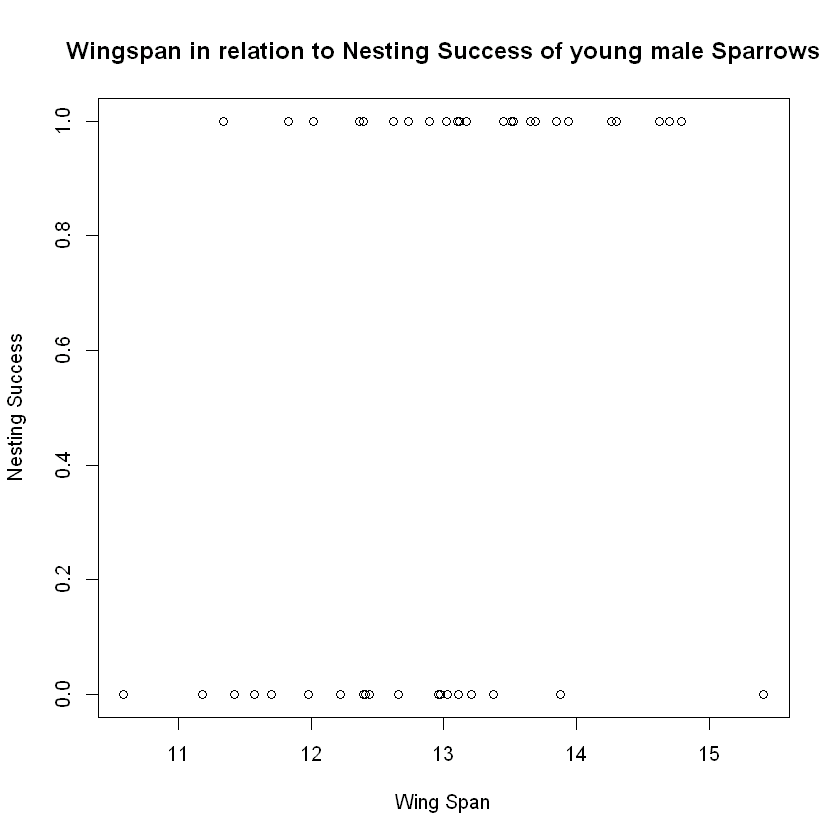

In [350]:
plot(wspan, y, 
     type="p", 
     xlab = "Wing Span", 
     ylab = "Nesting Success", 
     main = "Wingspan in relation to Nesting Success of young male Sparrows"
    )

In the above relation, we observe that young male sparrows who's wingspans are small tend to have a lower sucess rate at nesting than those with larger wingspands. The above model outlined should have the capabilities at cpaturing that relationship. 

In [351]:
X <- as.matrix(cbind(rep(1, length(wspan)), wspan))

In [352]:
log.ratio <- function(beta.proposal, beta.previous, y, X, mu0, sigma0) {
    # Likelihood difference (logistic regression)
    
    likelihood_diff <- sum(dbinom(y, size = 1, prob = 1 / (1 + exp(-X %*% beta.proposal)), log = TRUE)) -
                       sum(dbinom(y, size = 1, prob = 1 / (1 + exp(-X %*% beta.previous)), log = TRUE))
    
    # Prior difference (multivariate normal)
    prior_diff <- dmvnorm(t(beta.proposal), mean = mu0, sigma = sigma0, log = TRUE) -
                  dmvnorm(t(beta.previous), mean = mu0, sigma = sigma0, log = TRUE)
    
    # Total log-ratio
    return(likelihood_diff + prior_diff)
}


In [353]:
# Prior specificaations
beta <- as.matrix(c(-3.35, 0.2), nrow=3); sigma.prior <-  matrix(data = c(200,0,0,100), nrow = 2)

# proposal distribution
variances <- c(0.6,6,60)
# Metropolis Set up
S0 = 1000
BETA <- matrix(rep(NaN, S0*4*3), nrow = S0*3, ncol = 4)

set.seed(42)

row.index <- 1
for (variance in variances) {
  acceptance <- 0
  sig_proposal <- variance * solve(t(X) %*% X) 
  
  beta.current <- beta
  
  for (iter in 1:S0) {
    beta.proposal <- t(rmvnorm(1, mean = beta.current, sigma = sig_proposal))
    log_ratio <- log.ratio(beta.proposal = beta.proposal, beta.previous = beta.current, y = y, X= X, mu0 = beta, sigma0 = sigma.prior)
      
    if (log(runif(1)) < log_ratio) {
      beta.current <- beta.proposal
      acceptance <- acceptance + 1
    }

    BETA[row.index, 1:2] <- beta.current
    BETA[row.index, 3] <- log_ratio  
    BETA[row.index, 4] <- variance
    row.index <- row.index + 1
  }
  # Compute acceptance rate
  acceptance_rate <- acceptance / S0
  print(paste("Acceptance rate for variance", variance, ":", acceptance_rate))
    
}

[1] "Acceptance rate for variance 0.6 : 0.819"
[1] "Acceptance rate for variance 6 : 0.508"
[1] "Acceptance rate for variance 60 : 0.136"


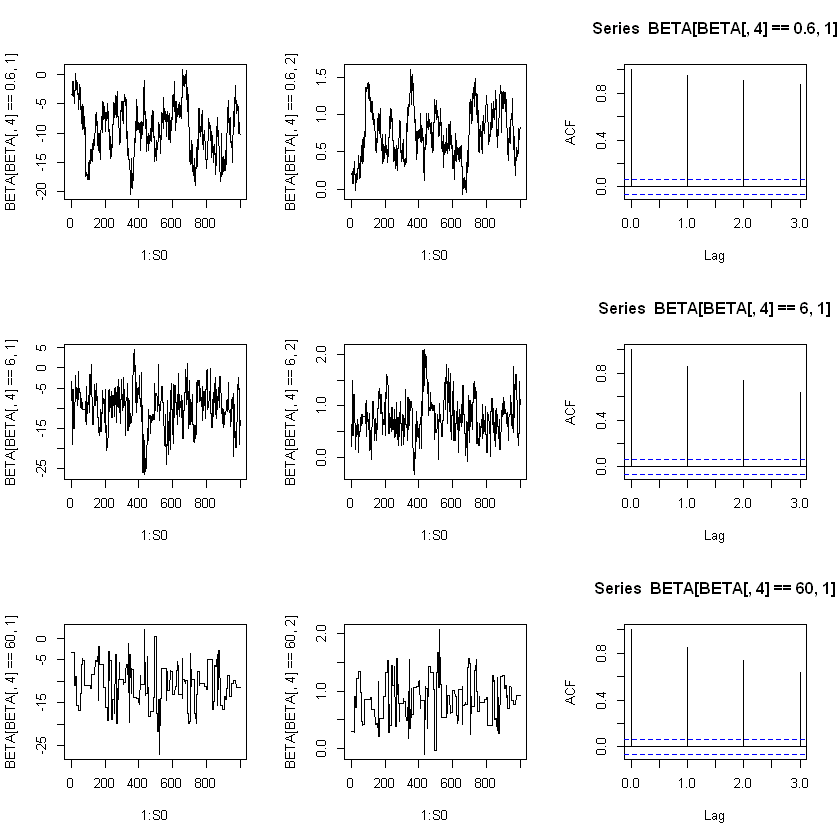

In [354]:
par(mfrow = c(3,3))
plot(1:S0, BETA[BETA[,4] == 0.6, 1], type="l")
plot(1:S0, BETA[BETA[,4] == 0.6, 2], type ="l")
acf(BETA[BETA[,4] == 0.6,1], lag.max = 3)

plot(1:S0, BETA[BETA[,4] == 6,1], type="l")
plot(1:S0, BETA[BETA[,4] == 6,2], type ="l")
acf(BETA[BETA[,4] == 6,1], lag.max = 3)

plot(1:S0, BETA[BETA[,4] == 60,1], type="l")
plot(1:S0, BETA[BETA[,4] == 60,2], type ="l")
acf(BETA[BETA[,4] == 60,1], lag.max = 3)

Looking at the acceptance rate ratios, I would pick the accaptance rate ratio of 50% corresponding to the proposal variance of 6. 

In [355]:
# Prior specificaations
beta <- as.matrix(c(-3.35, 0.2), nrow=3); sigma.prior <-  matrix(data = c(200,0,0,100), nrow = 2)

# Metropolis Set up
S = 20000
BETA_N <- matrix(rep(NaN, S*3), nrow = S, ncol = 3)

set.seed(42)

acceptance <- 0
sig_proposal <- 6 * solve(t(X) %*% X) 

beta.current <- beta
  
for (iter in 1:S) {
    beta.proposal <- t(rmvnorm(1, mean = beta.current, sigma = sig_proposal))
    log_ratio <- log.ratio(beta.proposal = beta.proposal, beta.previous = beta.current, y = y, X= X, mu0 = beta, sigma0 = sigma.prior)
      
    if (log(runif(1)) < log_ratio) {
      beta.current <- beta.proposal
      acceptance <- acceptance + 1
    }

    BETA_N[iter, 1:2] <- beta.current
    BETA_N[iter, 3] <- log_ratio  
}
acceptance_rate <- acceptance / S


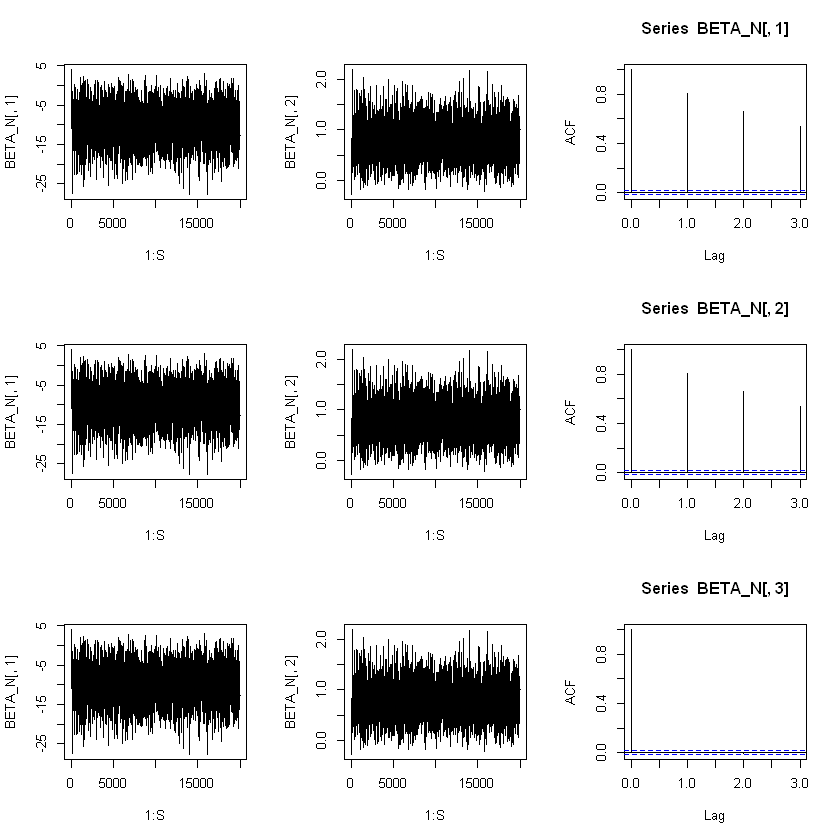

In [356]:
par(mfrow = c(3,3))
plot(1:S, BETA_N[, 1],type="l")
plot(1:S, BETA_N[, 2],type ="l")
acf(BETA_N[,1], lag.max = 3)

plot(1:S, BETA_N[, 1],type="l")
plot(1:S, BETA_N[, 2],type ="l")
acf(BETA_N[,2], lag.max = 3)

plot(1:S, BETA_N[, 1],type="l")
plot(1:S, BETA_N[, 2],type ="l")
acf(BETA_N[,3], lag.max = 3)

In [357]:
# MLE Estimate
glm(y~X[,2], family = "binomial")


Call:  glm(formula = y ~ X[, 2], family = "binomial")

Coefficients:
(Intercept)       X[, 2]  
    -9.7868       0.7758  

Degrees of Freedom: 42 Total (i.e. Null);  41 Residual
Null Deviance:	    59.03 
Residual Deviance: 53.38 	AIC: 57.38

In [358]:
Beta.df <- as.data.frame(BETA_N[,1:2])
colnames(Beta.df) <- c("Beta1", "Beta2")

beta.estimates <- Beta.df %>%
  summarise(across(
    everything(),
    list(
      mean = mean,
      `2.5%` = ~ quantile(.x, 0.025),
      `97.5%` = ~ quantile(.x, 0.975),
      se = ~sd(.x)/sqrt(n())
    ),
    .names = "{.col}_{.fn}"
  )) %>%
  pivot_longer(
    cols = everything(),
    names_to = c("beta", "stat"),
    names_sep = "_",
    values_to = "value"
  ) %>%
  pivot_wider(
    names_from = stat,
    values_from = value
  ) %>%
  column_to_rownames(var = "beta")


beta.estimates

,mean,2.5%,97.5%,se
,<dbl>,<dbl>,<dbl>,<dbl>
Beta1,-9.7684919,-18.8075294,-1.60259,0.031157717
Beta2,0.7748967,0.1433853,1.47293,0.002411139


The estimates for beta of the MLE and Metropolis Algorithm are very similar to one another.

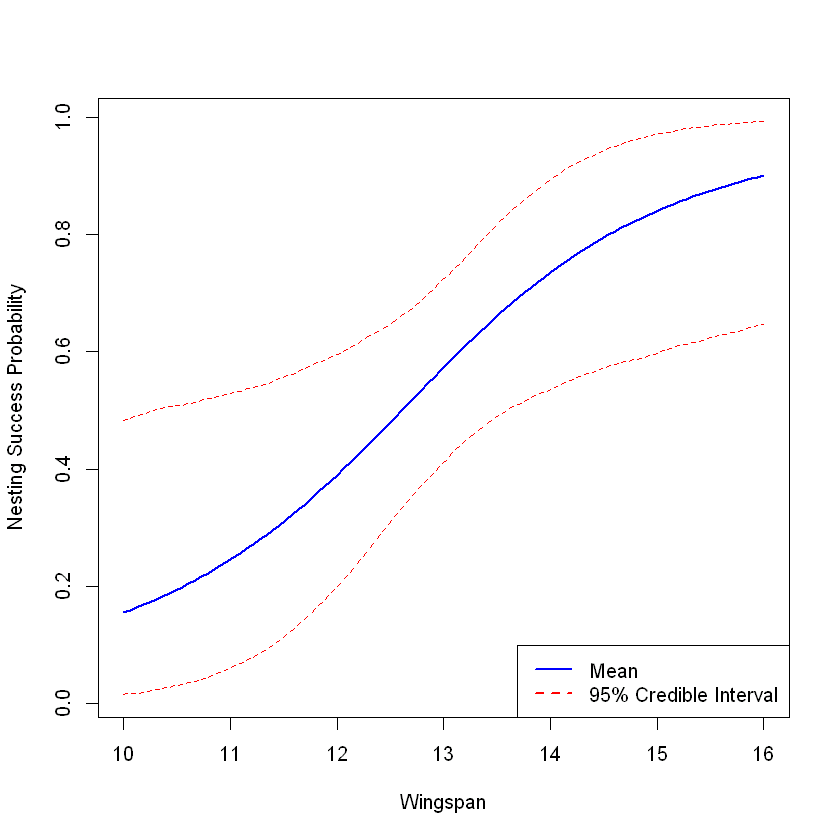

In [359]:
x_vals <- seq(10, 16, length.out = 100)

logistic_function <- function(beta1, beta2, x) {
  exp(beta1 + beta2 * x) / (1 + exp(beta1 + beta2 * x))
}

predictions <- sapply(x_vals, function(x) {
  logistic_function(Beta.df$Beta1, Beta.df$Beta2, x)
})

pred_summary <- apply(predictions, 2, function(pred) {
  c(mean = mean(pred), lower = quantile(pred, 0.025), upper = quantile(pred, 0.975))
})

pred_summary_df <- data.frame(
  x = x_vals,
  mean = pred_summary["mean", ],
  lower = pred_summary["lower.2.5%", ],
  upper = pred_summary["upper.97.5%", ]
)

plot(pred_summary_df$x, pred_summary_df$mean, type = "l", col = "blue", lwd = 2,
     ylab = "Nesting Success Probability", xlab = "Wingspan", ylim = range(pred_summary_df$lower, pred_summary_df$upper))
lines(pred_summary_df$x, pred_summary_df$lower, col = "red", lty = 2)
lines(pred_summary_df$x, pred_summary_df$upper, col = "red", lty = 2)
legend("bottomright", legend = c("Mean", "95% Credible Interval"), col = c("blue", "red"), lty = c(1, 2), lwd = 2)
